## Distracted-Driver-Detection 

### Problem Description

In this competition you are given driver images, each taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). Your goal is to predict the likelihood of what the driver is doing in each picture. 

The 10 classes to predict are as follows,
<br>
<br>
<table>
    <tr>
        <td>
            <li>c0: safe driving</li>
            <br>
            <li>c1: texting - right</li>
            <br>
            <li>c2: talking on the phone - right</li>
            <br>
            <li>c3: texting - left</li>
            <br>
            <li>c4: talking on the phone - left</li>
            <br>
            <li>c5: operating the radio</li>
            <br>
            <li>c6: drinking</li>
            <br>
            <li>c7: reaching behind</li>
            <br>
            <li>c8: hair and makeup</li>
            <br>
            <li>c9: talking to passenger</li>
        </td>
        <td>
           <img src="./supp/driver.gif" style="width:300;height:300px;">
        </td>
    </tr>

</table>


### Summary of Results

Using a 50-layer Residual Network (with the following parameters) the following scores (losses) were obtained.
<table> 
<li>10 Epochs</li>
<li>32 Batch Size</li>
<li>Adam Optimizer</li>
<li>Glorot Uniform Initializer</li>
    <tr> 
        <td>
            **Training Loss**
        </td>
        <td>
         0.93
        </td>
    </tr>
    <tr> 
        <td>
            **Validation Loss**
        </td>
        <td> 
        3.79
        </td>
    </tr>
    <tr> 
        <td>
            **Holdout Loss**
        </td>
        <td>
         2.64
        </td>
    </tr>
</table>

**Why the high losses? Simply put - we don't have enough resources to quickly iterate / hyper-parameter tune the model!** If more resources were available (RAM, CPU speed), we could hyper-parameter tune over grid searches and combat high bias / high variance, which this model currently suffers. [This is how you'd fix high bias/variance.](#improve)



### Import Dependencies and Define Functions

Let's begin by importing some useful dependencies and defining some key functions that we'll use throughout the notebook.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, 
                          Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model, load_model, save_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from sklearn.model_selection import StratifiedKFold, cross_validate, LeaveOneGroupOut

from PIL import Image

In [2]:
def PlotClassFrequency(class_counts):
    plt.figure(figsize=(15,4))
    plt.bar(class_counts.index,class_counts)
    plt.xlabel('class')
    plt.xticks(np.arange(0, 10, 1.0))
    plt.ylabel('count')
    plt.title('Number of Images per Class')
    plt.show()

def DescribeImageData(data):
    print('Average number of images: ' + str(np.mean(data)))
    print("Lowest image count: {}. At: {}".format(data.min(), data.idxmin()))
    print("Highest image count: {}. At: {}".format(data.max(), data.idxmax()))
    print(data.describe())
    
def CreateImgArray(height, width, channel, data, folder, save_labels = True):
    """
    Writes image files found in 'imgs/train' to array of shape
    [examples, height, width, channel]
    
    Arguments:
    height -- integer, height in pixels
    width --  integer, width in pixels
    channel -- integer, number of channels (or dimensions) for image (3 for RGB)
    data -- dataframe, containing associated image properties, such as:
            subject -> string, alpha-numeric code of participant in image
            classname -> string, the class name i.e. 'c0', 'c1', etc. 
            img -> string, image name
    folder -- string, either 'test' or 'train' folder containing the images
    save_labels -- bool, True if labels should be saved, or False (just save 'X' images array).  
                   Note: only applies if using train folder
            
    Returns:
    .npy file -- file, contains the associated conversion of images to numerical values for processing
    """
    
    num_examples = len(data)
    X = np.zeros((num_examples,height,width,channel))
    if (folder == 'train') & (save_labels == True):
        Y = np.zeros(num_examples)
    
    for m in range(num_examples):
        current_img = data.img[m]
        img_path = 'imgs/' + folder + '/' + current_img
        img = image.load_img(img_path, target_size=(height, width))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X[m] = x
        if (folder == 'train') & (save_labels == True):
            Y[m] = data.loc[data['img'] == current_img, 'classname'].iloc[0]
        
    np.save('X_'+ folder + '_' + str(height) + '_' + str(width), X)
    if (folder == 'train') & (save_labels == True):
        np.save('Y_'+ folder + '_' + str(height) + '_' + str(width), Y)
        
def Rescale(X):
    return (1/(2*np.max(X))) * X + 0.5

def PrintImage(X_scaled, index, Y = None):
    plt.imshow(X_scaled[index])
    if Y is not None:
        if Y.shape[1] == 1:
            print ("y = " + str(np.squeeze(Y[index])))
        else:
            print("y = " + str(np.argmax(Y[index])))
            
def LOGO(X, Y, group, model_name, input_shape, classes, init, optimizer, metrics, epochs, batch_size):
    logo = LeaveOneGroupOut()
    logo.get_n_splits(X, Y, group);
    cvscores = np.zeros((26,4))
    subject_id = []
    i = 0
    for train, test in logo.split(X, Y, group):
        # Create model
        model = model_name(input_shape = input_shape, classes = classes, init = init)
        # Compile the model
        model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=[metrics])
        # Fit the model
        model.fit(X[train], Y[train], epochs = epochs, batch_size = batch_size, verbose = 0)
        # Evaluate the model
        scores_train = model.evaluate(X[train], Y[train], verbose = 0)
        scores_test = model.evaluate(X[test], Y[test], verbose = 0)
        # Save to cvscores
        cvscores[i] = [scores_train[0], scores_train[1] * 100, scores_test[0], scores_test[1] * 100]
        subject_id.append(group.iloc[test[0]])
        # Clear session
        K.clear_session()
        # Update counter
        i += 1
        
    return pd.DataFrame(cvscores, index = subject_id, columns=['Train_loss', 'Train_acc','Test_loss', 'Test_acc'])

### Quick EDA

Let's begin by loading the provided dataset 'driver_imgs_list' doing a quick analysis. 

In [3]:
driver_imgs_df = pd.read_csv('driver_imgs_list/driver_imgs_list.csv')
driver_imgs_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


We can note the number of examples by printing the shape of the dataframe. Looks like the training set has 22,424 images.

In [4]:
driver_imgs_df.shape

(22424, 3)

We can plot the number of images per class to see if any classes have a low number of images.

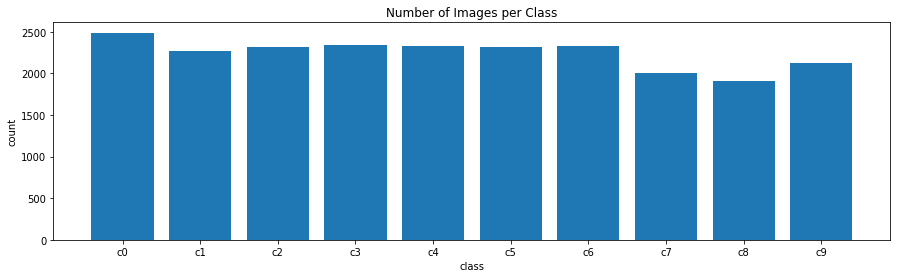

Average number of images: 2242.4
Lowest image count: 1911. At: c8
Highest image count: 2489. At: c0
count      10.000000
mean     2242.400000
std       175.387951
min      1911.000000
25%      2163.500000
50%      2314.500000
75%      2325.750000
max      2489.000000
Name: classname, dtype: float64


In [5]:
class_counts = (driver_imgs_df.classname).value_counts()
PlotClassFrequency(class_counts)
DescribeImageData(class_counts)

Additionally, we can plot the number of images per test subject. It would be much more helpful to plot the number of images belonging to each class *per subject*. We could then ensure that the distribution is somewhat uniform. We did not show this here, and instead just plotted number of images per subject.

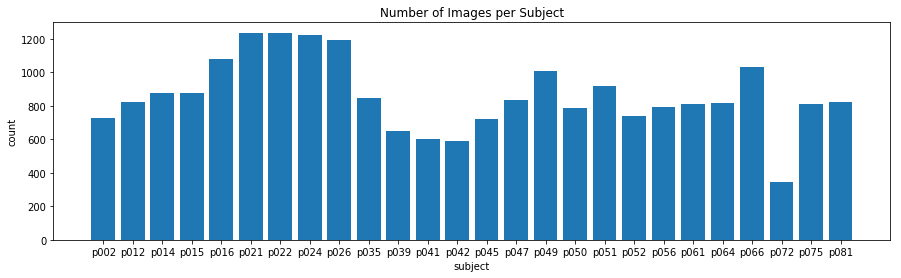

Average number of images: 862.461538462
Lowest image count: 346. At: p072
Highest image count: 1237. At: p021
count      26.000000
mean      862.461538
std       214.298713
min       346.000000
25%       752.500000
50%       823.000000
75%       988.250000
max      1237.000000
Name: subject, dtype: float64


In [6]:
subject_counts = (driver_imgs_df.subject).value_counts()
plt.figure(figsize=(15,4))
plt.bar(subject_counts.index,subject_counts)
plt.xlabel('subject')
plt.ylabel('count')
plt.title('Number of Images per Subject')
plt.show()
DescribeImageData(subject_counts)

Furthermore, we can check if there are any null image examples.

In [7]:
pd.isnull(driver_imgs_df).sum()

subject      0
classname    0
img          0
dtype: int64

### Preprocess Data

The data was provided with the classes in order (from class 0 to class 9). Let's shuffle the data by permutating the 'classname' and 'img' attributes.

In [8]:
np.random.seed(0)
myarray = np.random.permutation(driver_imgs_df)
driver_imgs_df = pd.DataFrame(data = myarray, columns=['subject', 'classname', 'img'])

We'll go ahead and apply a dictionary to the 'classname' attribute and assign the strings to their respective integers.

In [9]:
d = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
driver_imgs_df.classname = driver_imgs_df.classname.map(d)

### Convert Dataframe to Array for Training

Let's convert the images into numerical arrays of dimension '64, 64, 3'. Both the height and width of the images will be 64 pixels, and each image will have 3 channels (for red, green and blue). The following function saves the array as a .npy file.

In [39]:
CreateImgArray(64, 64, 3, driver_imgs_df, 'train')

Let's now load the new image arrays into the environment. Note that this step is used to save memory so that CreateImgArray does not have to be executed every time.

In [10]:
X = np.load('X_train_64_64.npy')
X.shape

(22424, 64, 64, 3)

In [11]:
Y = np.load('Y_train_64_64.npy')
Y.shape

(22424,)

Let's check our new arrays and ensure we compiled everything correctly. We can see that we do not have any entries in X that contain zero, and Y contains all the target labels.

In [12]:
(X == 0).sum()

0

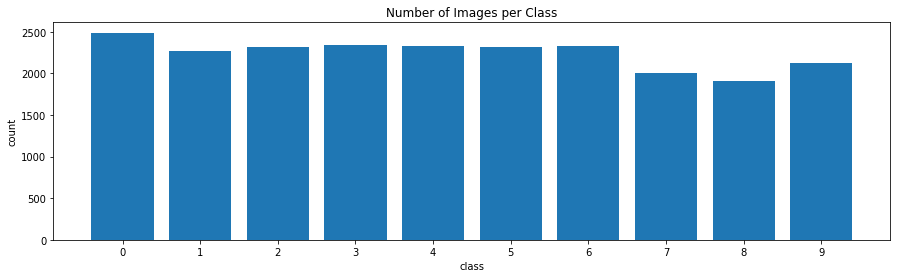

In [13]:
PlotClassFrequency(pd.DataFrame(Y)[0].value_counts())

Furthermore, we can print the images from X and the associated class as a sanity check. Re-scaling the images (between 0 and 1):

In [14]:
X_scaled = Rescale(X)

y = 7.0


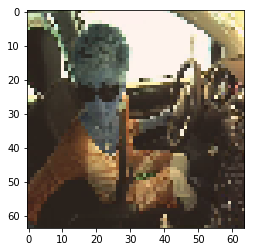

In [15]:
PrintImage(X_scaled, 2, Y = Y.reshape(-1,1))

Class of "7" corresponds to a driver "reaching behind", which appears to be the case shown above.

### Build the Model

We'll use the popular Residual Net with 50 layers. Residual networks are essential to preventing vanishing gradients when using a rather 'deep' network (many layers). The identity_block and convolutional_block are defined below.

In [16]:
def identity_block(X, f, filters, stage, block, init):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [17]:
def convolutional_block(X, f, filters, stage, block, init, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = init)(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

With the two blocks defined, we'll now create the model ResNet50, as shown below.

In [18]:
def ResNet50(input_shape = (64, 64, 3), classes = 10, init = glorot_uniform(seed=0)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = init)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1, init = init)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b', init = init)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c', init = init)

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2, init = init)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b', init = init)
    X = identity_block(X, 3, [128,128,512], stage=3, block='c', init = init)
    X = identity_block(X, 3, [128,128,512], stage=3, block='d', init = init)

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2, init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e', init = init)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f', init = init)

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2, init = init)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b', init = init)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c', init = init)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = init)(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    return model

### Cross Validation Training (Leave-One-Group-Out)

Let's do some basic transformation on the training / label arrays, and print the shapes. After, we'll define some key functions for use in our first CNN model.

In [19]:
# Normalize image vectors
X_train = X/255

# Convert training and test labels to one hot matrices
#Y = convert_to_one_hot(Y.astype(int), 10).T
Y_train = np.expand_dims(Y.astype(int), -1)

print ("number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

number of training examples = 22424
X_train shape: (22424, 64, 64, 3)
Y_train shape: (22424, 1)


Next, let's call our LOGO function that incorporates the Leave One Group Out cross-validator. This function will allow us to split the data using the drivers ('subject') as the group, which should help us prevent overfitting as the model will probably learn too much information off the type of driver/subject and become biased. 

Below we pass the arguments to the self-defined LOGO function and execute. The return is a dataframe consistering of the accuracy/loss scores of the training/dev sets (for each group/driver). 

In [25]:
scores = LOGO(X_train, Y_train, group = driver_imgs_df['subject'],
              model_name = ResNet50, input_shape = (64, 64, 3), classes = 10, 
              init = glorot_uniform(seed=0), optimizer = 'adam', metrics = 'accuracy',
              epochs = 2, batch_size = 32)

Plotting the dev set accuracy, we can see that 'p081' had the lowest accuracy at 8.07%, and 'p002' had the highest accuracy at 71.52%.

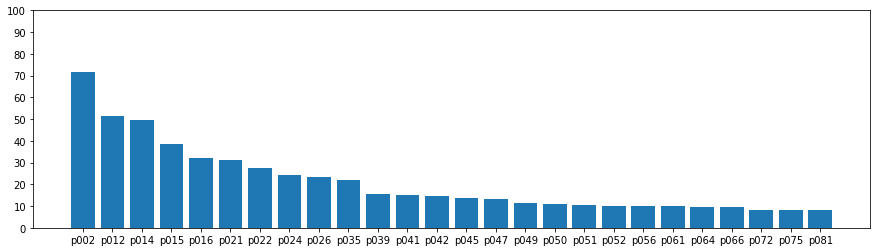

In [41]:
plt.figure(figsize=(15,4))
plt.bar(scores.index, scores.loc[:,'Test_acc'].sort_values(ascending=False))
plt.yticks(np.arange(0, 110, 10.0))
plt.show()

Calling 'describe' method, we can note some useful statistics.

In [42]:
scores.describe()

,Train_loss,Train_acc,Test_loss,Test_acc
count,26.000000,26.000000,26.000000,26.000000
mean,4.118791,27.908272,5.293537,21.190364
std,3.597604,19.144588,4.731039,16.150668
min,0.722578,8.477557,0.820852,8.070501
25%,1.849149,11.193114,2.133728,10.137083
50%,2.545475,25.507787,2.562653,14.259937
75%,5.299684,39.668163,8.664656,26.789961
max,14.751674,74.439192,14.553808,71.521739


And finally, let's print out the train/dev scores.

In [65]:
print("Train acc: {:.2f}. Dev. acc: {:.2f}".format(scores['Train_acc'].mean(), scores['Test_acc'].mean()))
print("Train loss: {:.2f}. Dev. loss: {:.2f}".format(scores['Train_loss'].mean(), scores['Test_loss'].mean()))

Train acc: 27.91. Dev. acc: 21.19
Train loss: 4.12. Dev. loss: 5.29


We can note that the train accuracy is higher than the dev accuracy, which is expected. The accuracy is quite low in comparison to our assumed Bayes accuracy of 100% (using human accuracy as a proxy to Bayes), and we have some variance (differnce between train and dev) of about 6.72%. Let's try increasing the number of epochs to 10 and observe if the train/dev accuracies increase (loss decreases).

In [66]:
scores = LOGO(X_train, Y_train, group = driver_imgs_df['subject'],
              model_name = ResNet50, input_shape = (64, 64, 3), classes = 10, 
              init = glorot_uniform(seed=0), optimizer = 'adam', metrics = 'accuracy',
              epochs = 5, batch_size = 32)

In [67]:
print("Train acc: {:.2f}. Dev. acc: {:.2f}".format(scores['Train_acc'].mean(), scores['Test_acc'].mean()))
print("Train loss: {:.2f}. Dev. loss: {:.2f}".format(scores['Train_loss'].mean(), scores['Test_loss'].mean()))

Train acc: 37.83. Dev. acc: 25.79
Train loss: 2.61. Dev. loss: 3.30


<a class="anchor" id="improve"></a>
The train and dev accuracy increased to 37.83% and 25.79%, respectively. We can note that we still have an underfitting problem (high bias, about 62.17% from 100%), *however, our variance has increased dramatically between 2 epochs and 5 by about 80% (12.04% variance)!* Not only do **we have high bias, but our model also exhibits high variance**. In order to tackle this, we'll need to address the high bias first (get as close to Bayes error as possible) and then deal with the resulting high variance. Note that ALL of the steps below should be performed with LOGO cross-validation. This way, we can be sure our estimates of the dev set are in line with the holdout set.

In order to tackle **high bias**, we can do any of the following:
<li>run more epochs</li>
<li>increase the batch size (up to number of examples)</li>
<li>make a deeper network</li>
<li>increases the image size from 64x64 to 128x128, 256x256, etc.</li>
<li>GridSearching over params (batch size, epoch, optimizer and it's parameters, initializer)</li>


Let's up the epoch count to 10. The assumption is that the train accuracy will be higher than the previous 5 epoch model, but our variance will increase.

In [75]:
scores = LOGO(X_train, Y_train, group = driver_imgs_df['subject'],
              model_name = ResNet50, input_shape = (64, 64, 3), classes = 10, 
              init = glorot_uniform(seed=0), optimizer = 'adam', metrics = 'accuracy',
              epochs = 10, batch_size = 32)

In [76]:
print("Train acc: {:.2f}. Dev. acc: {:.2f}".format(scores['Train_acc'].mean(), scores['Test_acc'].mean()))
print("Train loss: {:.2f}. Dev. loss: {:.2f}".format(scores['Train_loss'].mean(), scores['Test_loss'].mean()))

Train acc: 86.95. Dev. acc: 40.68
Train loss: 0.93. Dev. loss: 3.79


As expected, the training accuracy increased to 86.95%, but the variance increase from 5 epochs to 10 was about 284% (46.27% variance)! Thus, we can conclude that this model suffers from severe high variance. We can continue on and use the steps above to fix the remaining bias, then we can use the steps below to reduce the variance.

In order to tackle **high variance**, we can do any of the following:
<li>Augment images to increase sample size</li>
<li>Regularization</li>
<li>GridSearching over params (batch size, epoch, optimizer and it's parameters, initializer)</li>
<li>Decrease dev set size (allows more examples to be trained, making model less prone to overfitting)</li>
<li>Investigate classes with low accuracy, and fix them</li>

<table> 
    <tr> 
        <td>
            **Model**
        </td>
        <td>
           **Epoch**
        </td>
        <td>
         **Train Accuracy**
        </td>
        <td>
         **Dev Accuracy**
        </td>
        <td>
         **Bias**
        </td>
        <td>
         **Variance**
        </td>
    </tr>
    <tr>
        <td>
            **Model A**
        </td>
        <td>
           2
        </td>
        <td>
         27.91
        </td>
        <td>
         21.19
        </td>
        <td>
         72.09
        </td>
        <td>
         6.72
        </td>
    </tr>
    <tr> 
        <td>
            **Model B**
        </td>
        <td> 
        5
        </td>
        <td>
         37.83
        </td>
        <td>
         25.79
        </td>
        <td>
         62.17
        </td>
        <td>
         12.04
        </td>
    </tr>
    <tr> 
        <td>
            **Model C**
        </td>
        <td>
         10
        </td>
        <td>
         86.95
        </td>
        <td>
         40.68
        </td>
        <td>
         13.06
        </td>
        <td>
        46.27
        </td>
    </tr>
</table>


### Predictions on the Holdout Set 

We'll go ahead and fit the 10 epoch model  We'd like to confirm that our holdout score is somewhere around the dev score, so that we are not being particularily biased in our dev set, either. Creating, compiling and fitting the model,

In [87]:
model = ResNet50(input_shape = (64, 64, 3), classes = 10)
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
22424/22424 [==============================] - 83s 4ms/step - loss: 2.4026 - acc: 0.3128
Epoch 2/10
22424/22424 [==============================] - 76s 3ms/step - loss: 1.8118 - acc: 0.4996
Epoch 3/10
22424/22424 [==============================] - 76s 3ms/step - loss: 1.5023 - acc: 0.6153
Epoch 4/10
22424/22424 [==============================] - 76s 3ms/step - loss: 0.8445 - acc: 0.8483
Epoch 5/10
22424/22424 [==============================] - 76s 3ms/step - loss: 1.2427 - acc: 0.7447
Epoch 6/10
22424/22424 [==============================] - 76s 3ms/step - loss: 0.8930 - acc: 0.8216
Epoch 7/10
22424/22424 [==============================] - 76s 3ms/step - loss: 0.9400 - acc: 0.8144
Epoch 8/10
22424/22424 [==============================] - 76s 3ms/step - loss: 0.7440 - acc: 0.8748
Epoch 9/10
22424/22424 [==============================] - 76s 3ms/step - loss: 1.4076 - acc: 0.6559
Epoch 10/10
22424/22424 [==============================] - 76s 3ms/step - loss: 0.6796 - acc: 0.8135

In [88]:
save_model(model, 'e10.h5');

In [10]:
model = load_model('e10.h5')

Let's load the holdout data set from out 'test_file_names' csv file and then create the necessary array.

In [ ]:
holdout_imgs_df = pd.read_csv('test_file_names.csv')
holdout_imgs_df.rename(columns={"imagename": "img"}, inplace = True)

In [ ]:
CreateImgArray(64, 64, 3, holdout_imgs_df, 'test')

Again, we'll load the data here instead of having to run CreateImgArray repeatedly. 

In [11]:
X_holdout = np.load('X_test_64_64.npy')
X_holdout.shape

(79726, 64, 64, 3)

And now calling predictions on the holdout set, as shown below. MAKE SURE to clear the memory before this step!

In [12]:
probabilities = model.predict(X_holdout, batch_size = 32)

Saving the predictions to a .csv file for submission,

In [14]:
np.savetxt("test_results.csv", probabilities, delimiter=",")

If desired (as a sanity check) we can visually check our predictions by scaling the X_holdout array and then printing the image.

In [15]:
X_holdout_scaled = Rescale(X_holdout)

y = 9
y_pred = 9


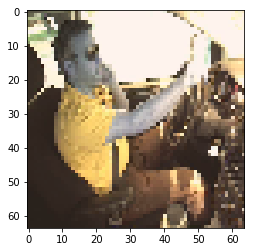

In [29]:
index = 50000
PrintImage(X_holdout_scaled, index = index, Y = probabilities)
print('y_pred = ' + str(probabilities[index].argmax()))